In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import pandas as pd
import numpy as np 

import create_model
import pickle
import time 

import random
import data_formatting

def validate(train):
    
    if train == True:
        
        model = train_model
        mode = 'TRAIN'
        
    else:
        mode = 'DEV'
        model = dev_model

    encoder, decoder, predicted = session.run([model.encoder_inputs, model.decoder_targets, model.decoder_pred_train])            

    print ('Current mode:%s' % mode)
    for i, (e_in, dt_targ, dt_pred) in enumerate(zip( encoder, decoder, predicted)):

        print('  sample {}:'.format(i + 1))
        #print('    enc input           > {}'.format(e_in))
        print('    enc input           > {}'.format(data_formatting.decodeSent(e_in, inv_map)))

        #print('    dec input           > {}'.format(dt_targ))
        print('    dec input           > {}'.format(data_formatting.decodeSent(dt_targ, inv_map)))

        #print('    dec train predicted > {}'.format(dt_pred))
        print('    dec train predicted > {}'.format(data_formatting.decodeSent(dt_pred, inv_map)))

        if i >= 0: break

In [2]:
dataset = 'enron'

vocab_dict = pickle.load(open('../processed_data/word_dict_v02_enron_py35_seq_length_3_49_sample_4256_limited_vocab.pkl', 'rb'))
df_all = pd.read_pickle('../processed_data/processed_data_v02_enron_py35_seq_length_3_49_sample_4256_limited_vocab.pkl')

#dataset = 'twitter'

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_25_sample_1764604_questions.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_25_sample_1764604_questions.pkl')

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_4_15_sample_134241_full.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_4_15_sample_134241_full.pkl')

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_19_sample_21946_lem.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_19_sample_21946_lem.pkl')

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_25_sample_1901567_full.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_25_sample_1901567_full.pkl')

In [3]:
inv_map = data_formatting.createInvMap(vocab_dict)

In [4]:
df_all['alpha_Pair_0_encoding'] = df_all['alpha_Pair_0_tokens'].apply(lambda x: data_formatting.encodeSent(x, vocab_dict))
df_all['alpha_Pair_1_encoding'] = df_all['alpha_Pair_1_tokens'].apply(lambda x: data_formatting.encodeSent(x, vocab_dict))
df_all['Index'] = df_all.index.values

In [5]:
df_all_train = df_all.sample(frac=0.97, random_state=1)

df_all_dev = df_all[df_all['Index'].isin(df_all_train['Index'].values) == False]

df_all_test = df_all_dev.sample(frac=0.10, random_state=1)

df_all_dev = df_all_dev[df_all_dev['Index'].isin(df_all_test['Index'].values) == False]

In [6]:
print (df_all.shape[0], df_all_train.shape[0],  df_all_dev.shape[0], df_all_test.shape[0], len(vocab_dict))

4256 4128 14 2 7239


In [7]:
train_data = data_formatting.prepare_train_batch(df_all_train['alpha_Pair_0_encoding'].values, 
                                                    df_all_train['alpha_Pair_1_encoding'].values)

dev_data = data_formatting.prepare_train_batch(df_all_dev['alpha_Pair_0_encoding'].values, 
                                                    df_all_dev['alpha_Pair_1_encoding'].values)

test_data = data_formatting.prepare_train_batch(df_all_test['alpha_Pair_0_encoding'].values, 
                                                    df_all_test['alpha_Pair_1_encoding'].values)

In [8]:
train_model_params = {'n_cells':256, 'num_layers':2, 'embedding_size':512, 
          'vocab_size':len(vocab_dict) + 1, 'minibatch_size':64, 'n_threads':128,
          'beam_width':10, 'limit_decode_steps': None,
          'encoder_input_keep':1, 'decoder_input_keep':1,
          'encoder_output_keep':1, 'decoder_output_keep':1,
         }

In [9]:
dev_model_params = train_model_params
dev_model_params['encoder_input_keep'] = 1
dev_model_params['encoder_output_keep'] = 1
dev_model_params['decoder_input_keep'] = 1
dev_model_params['decoder_output_keep'] = 1

In [10]:
training_params = { 'vocab_lower':3, 'vocab_upper':train_model_params['vocab_size']-1, 
                    'n_epochs':500000}

In [23]:
tf.reset_default_graph()

In [24]:
with tf.variable_scope('training_model'):
    
    train_model = create_model.Model(train_model_params, 'train', train_data)

with tf.variable_scope('training_model', reuse=True):

    dev_model = create_model.Model(dev_model_params, 'train', dev_data)    

In [25]:
global_step = tf.Variable(0, trainable=False)

starter_learning_rate = tf.placeholder(tf.float32, shape=(), name='starter_learning_rate')

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, \
                                   training_params['n_epochs'], 0.98, staircase=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(train_model.loss, global_step=global_step)

In [26]:
print_interval = 100
save_interval = 1000

lr = 0.001

train_loss = []
dev_loss = []

train_accuracy = []
dev_accuracy = []

learning_rate = []

with tf.Session() as session:

    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    coord = tf.train.Coordinator()

    threads = tf.train.start_queue_runners(coord=coord)
    #saver.restore(session, 'chkpt/seq2seq_twitter_test_2-5001')


    for epoch in range(training_params['n_epochs']):

        start_time = time.time()

        session.run(train_op, feed_dict={'starter_learning_rate:0':lr})
        #session.run(train_op)

        if epoch % print_interval == 0: 

            print ('epoch:%d, global_step:%s, learning rate:%.3g' % 
                       (epoch, tf.train.global_step(session, global_step), 
                        session.run(optimizer._lr, feed_dict={'starter_learning_rate:0':lr})))

            train_minibatch_loss,  train_minibatch_accuracy = session.run([train_model.loss, train_model.accuracy], 
                                                                          feed_dict={'starter_learning_rate:0':lr})

            train_loss.append([tf.train.global_step(session, global_step), train_minibatch_loss])  
            train_accuracy.append([tf.train.global_step(session, global_step), train_minibatch_accuracy])  

            print ('training minibatch loss:%.6g' % (train_minibatch_loss))
            print ('training minibatch accuracy:%.6g' % (train_minibatch_accuracy))

            validate(train=True)

            dev_model_loss, dev_model_accuracy = session.run([dev_model.loss, dev_model.accuracy])            

            print ('dev minibatch loss:%.6g' %  (dev_model_loss))
            print ('dev minibatch accuracy:%.6g' %  (dev_model_accuracy))

            dev_loss.append([tf.train.global_step(session, global_step), dev_model_loss])

            dev_accuracy.append([tf.train.global_step(session, global_step), dev_model_accuracy])

            learning_rate.append([tf.train.global_step(session, global_step), 
                                  session.run(optimizer._lr, feed_dict={'starter_learning_rate:0':lr})])

            validate(train=False)

            print ('Epoch:%d finished, time:%.4g' % (epoch, time.time() - start_time))

        if (epoch % save_interval == 0):# & (epoch!=0): 

            saver.save(session, '../chkpt/seq2seq_enron_testing', global_step = tf.train.global_step(session, global_step))

            print ('Session saved')

    coord.request_stop()
    coord.join(threads)

epoch:0, global_step:1, learning rate:0.001
training minibatch loss:8.86448
training minibatch accuracy:0.0315481
Current mode:TRAIN
  sample 1:
    enc input           > ['and', 'please', 'path', 'these', 'deals', 'in', 'unify', '<EOS>']
    dec input           > ['and', 'a', 'demand', 'of', 'on', 'deal', 'if', 'you', 'see', 'the', 'items', 'above', 'please', 'send', 'me', 'a', 'new', 'worksheet', 'and', 'please', 'path', 'these', 'deals', 'in', 'unify', '<EOS>']
    dec train predicted > ['lb', 'archive', 'archive', 'archive', 'm', 'management', 'telling', 'telling', 'management', '<EOS>', '<EOS>', 'defining', '<EOS>', '<EOS>', '<EOS>', '<EOS>', 'reference', 'piano', 'piano', 'party', 'party', 'party', 'americas', 'americas', 'fce', 'fce']
dev minibatch loss:8.86589
dev minibatch accuracy:0.0584416
Current mode:DEV
  sample 1:
    enc input           > ['i', 'll', 'tell', 'you', 'about', 'it', 'tomorrow', 'any', 'desire', 'to', 'go', 'running', 'in', 'the', 'park', 'tonight', '?', 'd

epoch:600, global_step:601, learning rate:0.001
training minibatch loss:2.96757
training minibatch accuracy:0.421753
Current mode:TRAIN
  sample 1:
    enc input           > ['you', 'leaving', 'around', 'or', 'so', '<EOS>']
    dec input           > ['they', 'work', 'thanks', '<EOS>']
    dec train predicted > ['i', 'like', '?', '<EOS>']
dev minibatch loss:6.75768
dev minibatch accuracy:0.221247
Current mode:DEV
  sample 1:
    enc input           > ['numbers', 'in', 'a', 'second', 'what', 's', 'the', 'status', 'of', 'these', 'two', 'deals', '?', 'them', 'all', 'deals', 'checked', 'out', 'fine', 'all', 'deals', 'checked', 'out', 'fine', 'enron', 'sells', 'to', 'ees', 'mw', 'of', 'may', 'pv', 'at', '<EOS>']
    dec input           > ['what', 's', 'the', 'status', 'of', 'these', 'two', 'deals', '?', 'them', 'all', 'deals', 'checked', 'out', 'fine', 'all', 'deals', 'checked', 'out', 'fine', 'enron', 'sells', 'to', 'ees', 'mw', 'of', 'may', 'pv', 'at', '<EOS>']
    dec train predicted > ['

dev minibatch loss:10.9667
dev minibatch accuracy:0.194058
Current mode:DEV
  sample 1:
    enc input           > ['to', 'strategize', 'about', 'things', 'not', 'sure', 'about', 'exactly', 'what', 'just', 'things', '<EOS>']
    dec input           > ['th', 'mtaylo', 'enroncom', 'responsibilities', 'thank', 'you', 'for', 'your', 'efforts', '<EOS>']
    dec train predicted > ['i', 'how', 'if', '<EOS>', '<EOS>', 'you', 'know', 'her', 'help', '<EOS>']
Epoch:1100 finished, time:1.627
epoch:1200, global_step:1201, learning rate:0.001
training minibatch loss:0.61774
training minibatch accuracy:0.841311
Current mode:TRAIN
  sample 1:
    enc input           > ['thanks', 'rosalee', 'mentioned', 'jeff', 'please', 'only', 'call', 'if', 'there', 'is', 'any', 'interest', 'through', 'just', 'wanted', 'to', 'check', 'in', 'and', 'see', 'if', 'this', 'rings', 'a', 'bell', 'with', 'you', 'thanks', '<EOS>']
    dec input           > ['priority', 'to', 'the', 'issue', 'mentioned', 'jeff', 'please', 'only

epoch:1900, global_step:1901, learning rate:0.001
training minibatch loss:0.0700792
training minibatch accuracy:0.990413
Current mode:TRAIN
  sample 1:
    enc input           > ['that', 'odn', 't', 'have', 'to', 'take', 'your', 'clothes', 'off', 'all', 'the', 'time', 'i', 'love', 'that', 'are', 'you', 'ok', '?', '<EOS>']
    dec input           > ['i', 'll', 'tell', 'you', 'about', 'it', 'tomorrow', 'any', 'desire', 'to', 'go', 'running', 'in', 'the', 'park', 'tonight', '?', 'did', 'you', 'call', 'earlier', 'today', '?', '<EOS>']
    dec train predicted > ['i', 'll', 'tell', 'you', 'so', 'it', 'tomorrow', 'any', 'desire', 'to', 'go', 'park', 'in', 'the', 'park', 'tonight', '?', 'did', 'you', 'call', 'earlier', 'today', '?', '<EOS>']
dev minibatch loss:16.5751
dev minibatch accuracy:0.202487
Current mode:DEV
  sample 1:
    enc input           > ['please', 'paraphrase', 'want', 'ticked', 'you', 'off', 'how', 'is', 'the', 'baby', '?', '<EOS>']
    dec input           > ['this', 'is', 'p

dev minibatch loss:16.3345
dev minibatch accuracy:0.271012
Current mode:DEV
  sample 1:
    enc input           > ['barry', 'thanks', 'for', 'the', 'offer', 'pm', 'please', 'let', 'me', 'know', 'if', 'you', 'can', 'attend', '<EOS>']
    dec input           > ['works', 'for', 'me', 'though', 'i', 'have', 'to', 'hop', 'at', 'pm', 'for', 'another', 'call', '<EOS>']
    dec train predicted > ['please', 'so', 'me', 'just', 'i', 'll', 'read', 'head', 'with', 'pm', 'i', 'something', 'calculations', 'what']
Epoch:2500 finished, time:1.741
epoch:2600, global_step:2601, learning rate:0.001
training minibatch loss:0.0400014
training minibatch accuracy:0.995585
Current mode:TRAIN
  sample 1:
    enc input           > ['signed', 'dash', 'message', 'as', 'to', 'the', 'purpose', 'of', 'the', 'epca', 'brokerage', 'account', 'thanks', '<EOS>']
    dec input           > ['nancy', 'please', 'let', 'me', 'know', 'asap', 'who', 'can', 'sign', 'for', 'epca', 'signed', 'dash', 'message', 'as', 'to', 'the', '

dev minibatch loss:14.3931
dev minibatch accuracy:0.267225
Current mode:DEV
  sample 1:
    enc input           > ['i', 'll', 'tell', 'you', 'about', 'it', 'tomorrow', 'any', 'desire', 'to', 'go', 'running', 'in', 'the', 'park', 'tonight', '?', 'did', 'you', 'call', 'earlier', 'today', '?', '<EOS>']
    dec input           > ['someone', 's', 'major', 'for', 'god', 'sakes', 'should', 'i', 'put', 'myself', 'on', 'ebay', '?', 'good', 'luck', 'think', 'positively', 'i', 'll', 'tell', 'you', 'about', 'it', 'tomorrow', 'any', 'desire', 'to', 'go', 'running', 'in', 'the', 'park', 'tonight', '?', 'did', 'you', 'call', 'earlier', 'today', '?', '<EOS>']
    dec train predicted > ['i', 'sorry', 'meeting', 'from', 'she', 's', 'she', 'i', 'get', 'that', 'on', 'your', 'how', '<EOS>', 'how', 'for', 'i', 'has', 'just', 'go', 'my', 'tomorrow', 'it', '<EOS>', 'enough', 'phone', 'to', 'go', 'off', '?', 'the', 'th', 'night', '?', '<EOS>', 'you', 'give', 'how', 'today', '?', '<EOS>']
Epoch:3200 finished, t

epoch:3800, global_step:3801, learning rate:0.001
training minibatch loss:0.00308973
training minibatch accuracy:1
Current mode:TRAIN
  sample 1:
    enc input           > ['certain', 'units', 'what', 'do', 'you', 'think', 'about', 'that', 'approach', '?', 'please', 'find', 'attached', 'my', 'versions', 'of', 'change', 'order', 'and', 'change', 'order', '<EOS>']
    dec input           > ['afternoon', 'i', 'll', 'find', 'you', 'tomorrow', 'certain', 'units', 'what', 'do', 'you', 'think', 'about', 'that', 'approach', '?', 'please', 'find', 'attached', 'my', 'versions', 'of', 'change', 'order', 'and', 'change', 'order', '<EOS>']
    dec train predicted > ['afternoon', 'i', 'll', 'find', 'you', 'tomorrow', 'certain', 'units', 'what', 'do', 'you', 'think', 'about', 'that', 'approach', '?', 'please', 'find', 'attached', 'my', 'versions', 'of', 'change', 'order', 'and', 'change', 'order', '<EOS>']
dev minibatch loss:18.6552
dev minibatch accuracy:0.197285
Current mode:DEV
  sample 1:
    enc

KeyboardInterrupt: 

In [15]:
session.close()

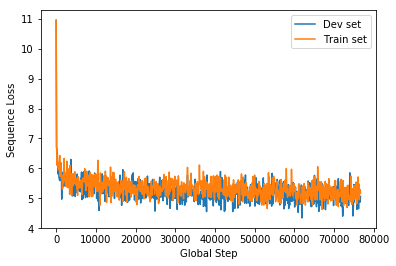

In [16]:
plt.plot(list(zip(*dev_loss))[0], list(zip(*dev_loss))[1], label='Dev set')
plt.plot(list(zip(*train_loss))[0], list(zip(*train_loss))[1], label='Train set')
plt.xlabel('Global Step')
plt.ylabel('Sequence Loss')
#plt.title('Seq2Seq Twitter Data')
#plt.title(' '.join(['%s:%d' % (i, j) for i,j in zip(model_params.keys(), model_params.values())]))
plt.legend(loc='best')
plt.show()

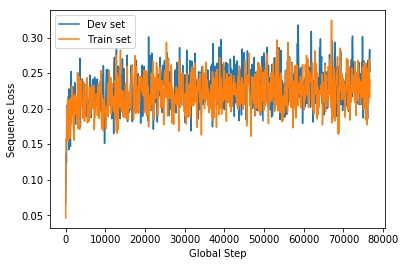

In [18]:
plt.plot(list(zip(*dev_accuracy))[0], list(zip(*dev_accuracy))[1], label='Dev set')
plt.plot(list(zip(*train_accuracy))[0], list(zip(*train_accuracy))[1], label='Train set')
plt.xlabel('Global Step')
plt.ylabel('Sequence Loss')
#plt.title('Seq2Seq Twitter Data')
#plt.title(' '.join(['%s:%d' % (i, j) for i,j in zip(model_params.keys(), model_params.values())]))
plt.legend(loc='best')
plt.show()

In [11]:
tf.reset_default_graph()

inf_model_params = {'n_cells':256, 'num_layers':2, 'embedding_size':512, 
          'vocab_size':len(vocab_dict) + 1, 'minibatch_size':64, 'n_threads':128,
          'beam_width':10, 'limit_decode_steps': None,
          'encoder_input_keep':1, 'decoder_input_keep':1,
          'encoder_output_keep':1, 'decoder_output_keep':1,
         }

with tf.variable_scope('training_model'):

    inf_model = create_model.Model(inf_model_params, 'infer', None)

In [47]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as session:
    
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
   
    #saver.restore(session, 'd:\coding\seq2seq_2\seq2seq\chkpt\seq2seq_twitter_queue-1')
    saver.restore(session, '../chkpt/seq2seq_enron_testing-1001')
    
    #train_data_encoder = data_formatting.encodeSent(['hi', 'enough', 'got', 'it', 'yet', '<EOS>'], vocab_dict)

    train_data_encoder = [i for i in train_data[0][30] if i!=0]
    
    train_data_decoder = train_data[2][30]
    
    #inf_out = session.run([inf_model.decoder_pred_decode, inf_model.decoder_pred_decode_prob], feed_dict_inf)
    inf_out = session.run([inf_model.encoder_inputs, inf_model.decoder_pred_decode],
            feed_dict = {'training_model/encoder_inputs:0':[train_data_encoder], 
                         'training_model/encoder_inputs_length:0':[len(train_data_encoder)]})
    
    encoder_input = inf_out[0]
    decoder_target = train_data_decoder
    decoder_inference = inf_out[1]

    for idx, e_in in enumerate(encoder_input):
                
        print ('###%d###' % idx)
        
        print ('INPUT:', data_formatting.decodeSent(e_in, inv_map))
        print ('OUTPUT:', data_formatting.decodeSent(decoder_target, inv_map))        
        try:
            beam_inf = list(zip(*decoder_inference[idx]))
            for idx_inf, dt_inf in enumerate(beam_inf):

                print ('INFERENCE:', data_formatting.decodeSent(dt_inf, inv_map))
                if idx_inf>20: break                
        except:
            print ('INFERENCE:', data_formatting.decodeSent(decoder_inference[idx], inv_map))

INFO:tensorflow:Restoring parameters from ../chkpt/seq2seq_enron_testing-1001
###0###
INPUT: ['the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
OUTPUT: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'time', 'pool', '<EOS>']


In [17]:
INFO:tensorflow:Restoring parameters from ../chkpt/seq2seq_enron_testing-1001
###0###
INPUT: ['the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
OUTPUT: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'time', 'pool', '<EOS>']

array([[ 269, 4812, 6999, 6070, 6999, 5846, 4812, 3929,  647,  601, 6887,
           1]], dtype=int64)

In [21]:
INFO:tensorflow:Restoring parameters from ../chkpt/seq2seq_enron_testing-2001
###0###
INPUT: ['the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
OUTPUT: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'rick', 'involved', 'thanks', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'list', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'rick', 'involved', '<EOS>', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'rick', 'involved', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'need', 'to', 'have', 'you', 'involved', 'thanks', '<EOS>', '<EOS>', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'time', 'book', 'the', 'information', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'need', 'to', 'have', 'you', 'involved', 'thanks', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'meeting', 'the', 'need', 'to', 'have', 'attend', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'call', 'change', 'i', 'need', 'to', 'have', 'the', 'meeting', 'folks', 's', 'a', 'daily', 'daily', '<EOS>']
INFERENCE: ['in', 'to', 'the', 'call', 'change', 'i', 'need', 'to', 'have', 'the', 'meeting', 'jeff', 'need', 'to', 'have', 'there', 'involved', '<EOS>']

array([list(['voice', 'mail', 'message', '<EOS>']),
       list(['twice', 'but', 'still', 'haven', 't', 'received', 'it', '<EOS>']),
       list([4571, 3723, 3576, 1]),
       list([4267, 4887, 540, 2019, 1505, 456, 6344, 1]), 1], dtype=object)

In [43]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['training_model/encoder_inputs',
 'training_model/encoder_inputs_length',
 'training_model/Shape',
 'training_model/strided_slice/stack',
 'training_model/strided_slice/stack_1',
 'training_model/strided_slice/stack_2',
 'training_model/strided_slice',
 'training_model/embedding_matrix/Initializer/random_uniform/shape',
 'training_model/embedding_matrix/Initializer/random_uniform/min',
 'training_model/embedding_matrix/Initializer/random_uniform/max',
 'training_model/embedding_matrix/Initializer/random_uniform/RandomUniform',
 'training_model/embedding_matrix/Initializer/random_uniform/sub',
 'training_model/embedding_matrix/Initializer/random_uniform/mul',
 'training_model/embedding_matrix/Initializer/random_uniform',
 'training_model/embedding_matrix',
 'training_model/embedding_matrix/Assign',
 'training_model/embedding_matrix/read',
 'training_model/embedding_lookup',
 'training_model/DropoutWrapperInit/Const',
 'training_model/DropoutWrapperInit/Const_1',
 'training_model/Dropou

In [19]:
output_node_names = [n.name for n in tf.get_default_graph().as_graph_def().node 
                         if 'decoder_pred' in n.name or 'encoder_input' in n.name]

In [20]:
output_node_names

['training_model/encoder_inputs',
 'training_model/encoder_inputs_length',
 'training_model/decoder_pred_decode']

In [49]:
[var for var in q if 'pred' in var.name]

[<tf.Operation 'training_model/decoder/while/BasicDecoderStep/cond/pred_id' type=Identity>,
 <tf.Operation 'training_model/decoder_pred_decode/dimension' type=Const>,
 <tf.Operation 'training_model/decoder_pred_decode' type=ArgMax>]

In [12]:
with tf.Session() as session:
    
    saver = tf.train.Saver()
   
    #saver.restore(session, 'd:\coding\seq2seq_2\seq2seq\chkpt\seq2seq_twitter_queue-1')
    saver.restore(session, '../chkpt/seq2seq_enron_testing-2001')
    q = session.graph.get_operations()
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        session, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        ['training_model/encoder_inputs',
 'training_model/encoder_inputs_length',
 'training_model/decoder_pred_decode'] # The output node names are used to select the usefull nodes
    ) 
    

     #Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile('frozen_model.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))

INFO:tensorflow:Restoring parameters from ../chkpt/seq2seq_enron_testing-2001
INFO:tensorflow:Froze 15 variables.
Converted 15 variables to const ops.
1158 ops in the final graph.


In [2]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def)
    return graph

In [3]:
from tensorflow.contrib.seq2seq.python.ops import beam_search_ops

In [5]:
# We use our "load_graph" function
graph = load_graph('..//seq2seq_twitter_n_cells_512_limit_decode_steps_None_vocab_size_38752_embedding_size_2048_num_layers_2_beam_width_10.pb')

vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_25_sample_1764604_questions.pkl', 'rb'))

inv_map = data_formatting.createInvMap(vocab_dict)

In [6]:
# We can verify that we can access the list of operations in the graph
for op in graph.get_operations():
    print(op.name)

import/training_model/encoder_inputs
import/training_model/encoder_inputs_length
import/training_model/Shape
import/training_model/strided_slice/stack
import/training_model/strided_slice/stack_1
import/training_model/strided_slice/stack_2
import/training_model/strided_slice
import/training_model/embedding_matrix
import/training_model/embedding_matrix/read
import/training_model/embedding_lookup
import/training_model/Rank
import/training_model/range/start
import/training_model/range/delta
import/training_model/range
import/training_model/concat/values_0
import/training_model/concat/axis
import/training_model/concat
import/training_model/transpose
import/training_model/sequence_length
import/training_model/rnn/Shape
import/training_model/rnn/strided_slice/stack
import/training_model/rnn/strided_slice/stack_1
import/training_model/rnn/strided_slice/stack_2
import/training_model/rnn/strided_slice
import/training_model/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/LSTMCellZeroState/Expan

import/training_model/decoder/while/BeamSearchDecoderStep/Reshape_35
import/training_model/decoder/while/BeamSearchDecoderStep/Reshape_36/shape/1
import/training_model/decoder/while/BeamSearchDecoderStep/Reshape_36/shape
import/training_model/decoder/while/BeamSearchDecoderStep/Reshape_36
import/training_model/decoder/while/BeamSearchDecoderStep/Gather_6
import/training_model/decoder/while/BeamSearchDecoderStep/Shape_24
import/training_model/decoder/while/BeamSearchDecoderStep/strided_slice_21/stack
import/training_model/decoder/while/BeamSearchDecoderStep/strided_slice_21/stack_1
import/training_model/decoder/while/BeamSearchDecoderStep/strided_slice_21/stack_2
import/training_model/decoder/while/BeamSearchDecoderStep/strided_slice_21
import/training_model/decoder/while/BeamSearchDecoderStep/Reshape_37
import/training_model/decoder/while/BeamSearchDecoderStep/mul_22/y
import/training_model/decoder/while/BeamSearchDecoderStep/mul_22
import/training_model/decoder/while/BeamSearchDecoder

In [6]:
# We access the input and output nodes 
x = graph.get_tensor_by_name('prefix/training_model/encoder_inputs:0')
x_len = graph.get_tensor_by_name('prefix/training_model/encoder_inputs_length:0')

y = graph.get_tensor_by_name('prefix/training_model/decoder_pred_decode:0')

In [7]:
df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_25_sample_1764604_questions.pkl')

In [8]:
df.head()

NameError: name 'df' is not defined

In [13]:
# We launch a Session
with tf.Session(graph=graph) as sess:
    
    #train_data_encoder = [i for i in train_data[0][30] if i!=0]
    train_data_encoder = data_formatting.encodeSent('who is hilary clinton ? <EOS>', vocab_dict)
    #train_data_decoder = train_data[2][30]
    train_data_decoder = None
    inf_out = sess.run(y, feed_dict={x:[train_data_encoder], x_len:[len(train_data_encoder)]})
    
    encoder_input = [train_data_encoder]
    decoder_target = train_data_decoder
    decoder_inference = [inf_out[0]]
    
    for idx, e_in in enumerate(encoder_input):
                
        print ('###%d###' % idx)
        
        print ('INPUT:', data_formatting.decodeSent(e_in, inv_map))
        
        if train_data_decoder is not None:
            print ('OUTPUT:', data_formatting.decodeSent(decoder_target, inv_map))        
        
        try:
            beam_inf = list(zip(*decoder_inference[idx]))
            for idx_inf, dt_inf in enumerate(beam_inf):

                print ('INFERENCE:', data_formatting.decodeSent(dt_inf, inv_map))
                #if idx_inf>20: break                
        except:
            print ('INFERENCE:', data_formatting.decodeSent(decoder_inference[idx], inv_map))

###0###
INPUT: ['who', 'is', 'hilary', 'clinton', '?', '<EOS>']
INFERENCE: ['she', 's', 'a', 'liar', '<EOS>', '<EOS>']
INFERENCE: ['she', 's', 'the', 'best', '<EOS>', '<EOS>']
INFERENCE: ['i', 'think', 'she', 's', 'the', 'only', 'one', '<EOS>', '<EOS>']
INFERENCE: ['i', 'think', 'she', 's', 'the', 'only', 'one', 'who', 'doesn', 't', 'care', 'about', 'her', '<EOS>']
INFERENCE: ['i', 'think', 'she', 's', 'the', 'only', 'one', 'who', 'doesn', 't', 'know', 'what', 'she', 'said', '<EOS>']
INFERENCE: ['she', 's', 'a', 'liar', '<EOS>']
INFERENCE: ['i', 'think', 'she', 's', 'the', 'only', 'one', 'who', 'doesn', 't', 'know', 'what', 'she', 'want', '<EOS>', '<EOS>']
INFERENCE: ['she', 's', 'the', 'best', '<EOS>']
INFERENCE: ['i', 'think', 'she', 's', 'the', 'only', 'one', 'who', 'doesn', 't', 'know', 'what', 'she', 's', 'saying', '<EOS>']
INFERENCE: ['i', 'think', 'she', 's', 'the', 'only', 'one', '<EOS>']
